<a href="https://colab.research.google.com/github/koba341/AutoML/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection



*   Auswahl Hyperparameter
*   Training mit Feature Selection
*   Entscheidungsprozess bei Lasso, Ridge und Elastic



**Bemerkungen 17.06.**
1.   Wenn etwas programmiert wird, Hintergrundinformationen mitliefern: Wie funktioniert ein Gaussprozess zb... Zu RandomForest zB nichts schreiben, da sehr bekannt 
2.   Hperparametersuche mit AutoML und NSGA II
3.   Diagramme wie https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py einbauen und erklären
4.   Bei allen Verfahrne nochmal Algorithmus kurz zeigen und Entscheidungsprozess für die selected Features erklären + Diagramme
5.   Github auf Privat stellen, Farzad Access geben
6.   R2 definieren - welches R2 wird genutzt? Manche geben negative Werte, manche nicht - unbedingt definieren.
7.   Bei Modellerstellung: Immer NSGA II (+ gewünschte Modelle) und AutoML zuerst nutzen - Hyperparameter Optimization
8.   Ensembles auch erstellen. Ensembles mit gemischten Algorithmen bei den traditionellen Methoden. Alles nutzen. Nächster Schritt: Ensembles mit neuronalen Netzwerken aus NAS.
9.  Beide Concrete Datensätze nutzen (das mit 1000 und 100 Datenpunkten)




In [1]:
# import needed packages
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from heapq import nlargest

In [2]:
#import the data set
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AutoML/slump_test.csv")
X = data.iloc[:, 1:10].to_numpy()
y = data.iloc[:, 10].to_numpy()


X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, train_size=0.90,random_state=1) # create training and test dataset. 

# print some information
print('Size of X: ', X.shape)
print('Size of X_train: ', X_train.shape)
print('Size of X_test: ', X_test.shape)
print(data.head())

Size of X:  (103, 9)
Size of X_train:  (92, 9)
Size of X_test:  (11, 9)
   No  Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0   1   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1   2   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2   3   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3   4   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4   5   154.0  112.0    144.0  220.0  10.0         923.0       658.0   

   SLUMP(cm)  FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0       23.0      62.0                               34.99  
1        0.0      20.0                               41.14  
2        1.0      20.0                               41.81  
3        3.0      21.5                               42.08  
4       20.0      64.0                               26.82  


# p-Value

In [ ]:
f_stat, p_val = f_regression(X_train, y_train)
print(f_stat)
print()
print(p_val)

[23.81702706  9.54253105 23.03769415  8.52436021  0.16074755  2.33534826
  2.46413992  6.22919137  2.68867538]

[4.55546206e-06 2.67047841e-03 6.28108989e-06 4.42727135e-03
 6.89419463e-01 1.29973780e-01 1.19980724e-01 1.43880487e-02
 1.04554728e-01]


# ANOVA

Example from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html \\
Intuition: https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w \\
**Offene Fragen 17.06:** 

1.   Wie wählt SelectKBest die k besten Features aus? Was ist das "beste"?



In [ ]:
k = 6
anova_filter = SelectKBest(f_regression, k=k)
X_new = anova_filter.fit_transform(X_train, y_train)

print('Shape of X: ', X_train.shape)
print('Shape of X after ANOVA: ', X_new.shape)
idx = np.argsort(anova_filter.scores_)[::-1][:k]+1 #+1 because of No. - Attribute
print('Selected Features: ', data.columns[idx])
idx = np.argsort(anova_filter.scores_)[::-1][:k]

Shape of X:  (92, 9)
Shape of X after ANOVA:  (92, 6)
Selected Features:  Index(['Cement', 'Fly ash', 'Slag', 'Water', 'SLUMP(cm)', 'FLOW(cm)'], dtype='object')


In [ ]:
!pip install gpytorch
import gpytorch
import torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 27.1 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=e7e2a5086ca7f426a2281441281df0a623654ca8a93ae1b7f610dd524e188565
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [ ]:
x_train = torch.from_numpy(X_new)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(X_test[:, idx.tolist()])

[1, 3, 2, 4, 8, 9]

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50000
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Iter 24014/50000 - Loss: 2.469   lengthscale: 120.656   noise: 2.499
Iter 24015/50000 - Loss: 2.469   lengthscale: 120.657   noise: 2.499
Iter 24016/50000 - Loss: 2.469   lengthscale: 120.657   noise: 2.498
Iter 24017/50000 - Loss: 2.469   lengthscale: 120.658   noise: 2.499
Iter 24018/50000 - Loss: 2.469   lengthscale: 120.658   noise: 2.498
Iter 24019/50000 - Loss: 2.469   lengthscale: 120.659   noise: 2.499
Iter 24020/50000 - Loss: 2.469   lengthscale: 120.659   noise: 2.499
Iter 24021/50000 - Loss: 2.469   lengthscale: 120.660   noise: 2.499
Iter 24022/50000 - Loss: 2.469   lengthscale: 120.660   noise: 2.499
Iter 24023/50000 - Loss: 2.469   lengthscale: 120.661   noise: 2.499
Iter 24024/50000 - Loss: 2.469   lengthscale: 120.661   noise: 2.499
Iter 24025/50000 - Loss: 2.469   lengthscale: 120.662   noise: 2.499
Iter 24026/50000 - Loss: 2.469   lengthscale: 120.662   noise: 2.499
Iter 24027/50000 - Loss: 2.469   len

KeyboardInterrupt: ignored

In [ ]:
model.eval()
likelihood.eval()

f_preds = model(x_test)
y_preds = likelihood(model(x_test))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

In [ ]:
print(y_test)
print(f_mean)

[28.29 35.66 33.78 31.9  48.77 34.99 32.04 30.97 35.39 45.42 44.08]
tensor([33.9070, 42.7437, 23.4072, 38.7692, 36.6042, 23.7531, 39.3912, 29.9616,
        24.0531, 32.1643, 34.2632], dtype=torch.float64,
       grad_fn=<ViewBackward0>)


In [ ]:
r2 = sklearn.metrics.r2_score(y_test, f_mean.detach().numpy())
print('R2: ', r2)

R2:  -1.2053774265989134


# Lasso
Example from : https://www.yourdatateacher.com/2021/05/05/feature-selection-in-machine-learning-using-lasso-regression/ \\
https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b \\
It is used differently in the links above \\
Code etc: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html \\
How to select alpha? We try following things:


1.   GridSearch
2.   CrossValidation



1. GridSearch

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

# make pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso()) ])

# perform grid search to find the best parameters for alpha
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, # from 0.1 to 10 in 0.1 steps
                      cv = 5, scoring="neg_mean_squared_error",verbose=0)

# fit the grid search
search.fit(X_train,y_train)

# print parameters
print(search.best_params_)

# coefficients of lasso regression
coefficients = search.best_estimator_.named_steps['model'].coef_

# importance of coefficient is the absolute value
importance = np.abs(coefficients)
print('Importance of Features: ', importance)

# print names of inputs that survived lasso
data_columns = data.columns.tolist()
data_columns.remove('Compressive Strength (28-day)(Mpa)')
data_columns.remove('No')

# show index above 0:
idx = np.where(importance > 0)[0]
idx_2 = np.where(importance==0)[0]
print('Features: ', data_columns)
print('Selected Features: ', [data_columns[i] for i in idx])
print('Deleted Features: ', [data_columns[i] for i in idx_2])

{'model__alpha': 0.1}
Importance of Features:  [6.44207973 0.         6.10473161 2.42133079 0.54468175 1.82667098
 0.28137666 0.89259506 0.        ]
Features:  ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)']
Selected Features:  ['Cement', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)']
Deleted Features:  ['Slag', 'FLOW(cm)']


2. CrossValidation \\
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV \\
https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation \\

What should be also tried: Leave-One-Out as CV.

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# make pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',LassoCV(cv=5)) ])

model = pipeline.fit(X_train, y_train)
lasso = model[-1] # access LassoCV from pipeline
importance = np.abs(lasso.coef_)
print('Used alpha value: ', lasso.alpha_)
print('Importance of Features: ', importance)

Used alpha value:  0.014695810039783394
Importance of Features:  [6.00408175 0.44692582 5.51631735 3.37076497 0.44847189 2.68208439
 0.99651385 1.78935464 1.19098207]


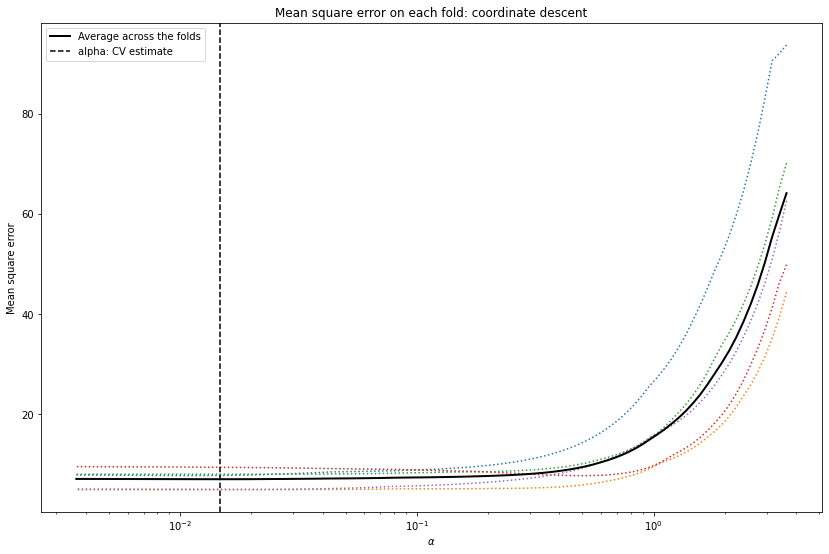

In [ ]:
import matplotlib.pyplot as plt


lasso = model[-1]
plt.figure(figsize=(14,9))
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent"
)

# Ridge Regression

How to decide which Features to select? https://stats.stackexchange.com/questions/506397/how-to-select-the-best-feature-set-from-ridge-regression

Wie genau funktioniert Ridge Regression? Welche Faktoren sind wichtig? Hyperparameterauswahl mit AutoML und NSGAII - GridSearch ist veraltet.



1. GridSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge

# make pipeline
pipeline = Pipeline([
                     ('scaler', StandardScaler()),
                     ('model', Ridge()) ])

# perform grid search to find the best parameters for alpha
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=0)

# fit the grid search
search.fit(X_train,y_train)

# print parameters
print(search.best_params_)

# coefficients of ridge regression
coefficients = search.best_estimator_.named_steps['model'].coef_

# importance of coefficient is the absolute value
importance = np.abs(coefficients)
print('Importance of Features: ', importance)

# print names of inputs that survived lasso
data_columns = data.columns.tolist()
data_columns.remove('Compressive Strength (28-day)(Mpa)')
data_columns.remove('No')

# show index above 0:
idx = np.where(importance > 0)[0]
idx_2 = np.where(importance==0)[0]
print('Features: ', data_columns)
print('Selected Features: ', [data_columns[i] for i in idx])
print('Deleted Features: ', [data_columns[i] for i in idx_2])

{'model__alpha': 0.6}
Importance of Features:  [5.05714316 1.42681505 4.50384004 4.08790615 0.33019898 3.82128621
 1.96490982 1.8557307  1.25816021]
Features:  ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)']
Selected Features:  ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)']
Deleted Features:  []


2. Cross-Validation

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# make pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',RidgeCV(alphas=np.linspace(0.01, 10, 100), store_cv_values=True)) ])

model = pipeline.fit(X_train, y_train)
ridge= model[-1] # access RidgeCV from pipeline
importance = np.abs(ridge.coef_)
print('Used alpha value: ', ridge.alpha_)
print('Importance of Features: ', importance)

Used alpha value:  1.220909090909091
Importance of Features:  [5.11439178 1.32962785 4.58672775 3.90324192 0.35244334 3.63956549
 1.82978508 1.74824247 1.10210064]


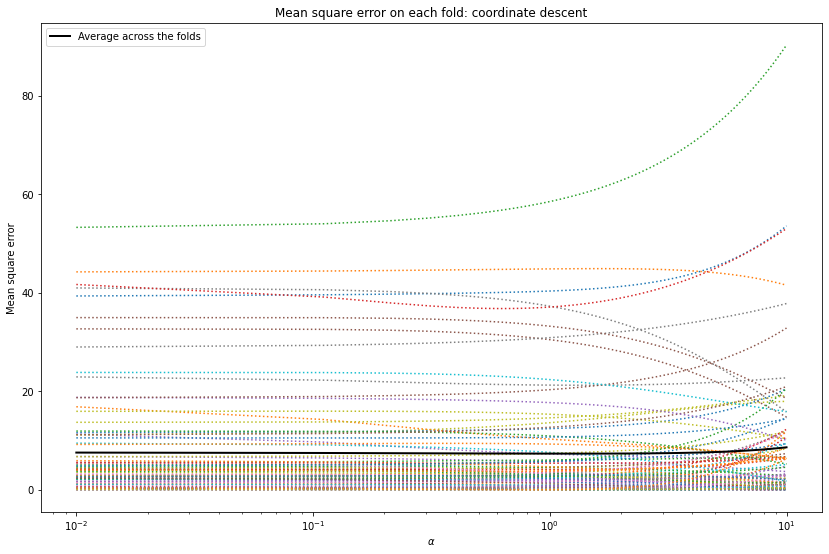

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,9))
plt.semilogx(ridge.alphas, ridge.cv_values_.T, linestyle=":")
plt.plot(
    ridge.alphas,
    ridge.cv_values_.T.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

#plt.axvline(ridge.alphas, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent"
)

# Elastic net
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet

# make pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model', ElasticNet()) ])

# perform grid search to find the best parameters for alpha and for l1 ratio
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, 
                      cv = 5, scoring="neg_mean_squared_error",verbose=0)

# fit the grid search
search.fit(X_train,y_train)

# print parameters
print(search.best_params_)

# coefficients of elastic net regression
coefficients = search.best_estimator_.named_steps['model'].coef_

# importance of coefficient is the absolute value
importance = np.abs(coefficients)
print('Importance of Features: ', importance)

# print names of inputs that survived lasso
data_columns = data.columns.tolist()
data_columns.remove('Compressive Strength (28-day)(Mpa)')
data_columns.remove('No')

# show index above 0:
idx = np.where(importance > 0)[0]
idx_2 = np.where(importance==0)[0]
print('Features: ', data_columns)
print('Selected Features: ', [data_columns[i] for i in idx])
print('Deleted Features: ', [data_columns[i] for i in idx_2])

{'model__alpha': 0.1}
Importance of Features:  [5.11534278 1.01781688 4.71509659 3.04234871 0.36520457 2.92107141
 1.30393888 1.07147692 0.13740644]
Features:  ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)']
Selected Features:  ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)']
Deleted Features:  []


In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# make pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model', ElasticNetCV(cv=5, l1_ratio=np.arange(0.1, 1, 0.1).tolist())) ])

model = pipeline.fit(X_train, y_train)
elastic = model[-1] # access RidgeCV from pipeline
importance = np.abs(ridge.coef_)
print('Used alpha value: ', elastic.alpha_, 'Used l1 ratio: ', elastic.l1_ratio_)
print('Importance', importance)

Used alpha value:  0.012134214527231013 Used l1 ratio:  0.30000000000000004
Importance [5.23513212 1.23760199 4.69859911 3.9304142  0.35223006 3.5955429
 1.77291628 1.80764194 1.19950005]


In [ ]:
import matplotlib.pyplot as plt

# didnt work yet.
elastic = model[-1]
plt.figure(figsize=(14,9))
plt.semilogx(elastic.alphas_, elastic.mse_path_[:,:,0], linestyle=":")
plt.plot(
    elastic.alphas_,
    elastic.mse_path_[:,:,0].mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(elastic.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent"
)